In [1]:
import sys
sys.path.append('/fsx/matzeni/duck')

In [2]:
import torch
import h5py
import json
from pathlib import Path
import pickle
from tqdm import tqdm
import logging
from transformers import AutoTokenizer
from typing import Any, Dict, List, Optional, Tuple
import copy
from einops import rearrange, repeat
import numpy as np
from duck.box_tensors import BoxTensor
from duck.task.duck_entity_disambiguation import Duck, BoxEDistance
from hydra import compose, initialize
import hydra
from duck.common.utils import seed_prg
import collections
import logging
import math
from duck.box_tensors.functional import cat_box
from matplotlib import pyplot as plt
from duck.common.utils import cartesian_to_spherical, load_json
from einops import repeat, rearrange
import pandas as pd

In [3]:
initialize(config_path="../conf", version_base=None)

hydra.initialize()

In [4]:
config = compose(
    config_name="duck",
    overrides=[]
)

In [5]:
ckpt_path = "/checkpoints/matzeni/duck/checkpoints/duck/duck_hard_epoch=0_val_f1=0.878.ckpt"
duck = Duck.load_from_checkpoint(ckpt_path).eval().cuda()

In [6]:
datamodule = duck.data

In [7]:
def batch_to_cuda(batch):
    if isinstance(batch, torch.Tensor):
        return batch.cuda()
    if isinstance(batch, collections.abc.Mapping):
        return {k: batch_to_cuda(v) for k, v in batch.items()}
    if isinstance(batch, str):
        return batch
    if isinstance(batch, collections.abc.Sequence):
        return [batch_to_cuda(v) for v in batch]
    return batch

In [8]:
seed_prg(ngpus=config.trainer.devices)
train_data = datamodule.train_dataloader()
train_data_iterator = iter(train_data)

In [9]:
duck.eval()
torch.set_grad_enabled(False)

# Distribution of entity embeddings and boxes on AIDA

In [10]:
entity_boxes = []
entities = []
torch.cuda.empty_cache()
max_iter = 100
i = 1
for batch in tqdm(train_data):
    i = i + 1
    batch = batch_to_cuda(batch)
    representations = duck(batch)
    mask = batch["relation_ids"]["attention_mask"].bool()
    entity_boxes.append(
        representations["entity_boxes"][mask]
    )
    entities.append(
        representations["entities"]
    )
    if i >= max_iter:
        break

  8%|▊         | 98/1153 [00:13<02:28,  7.09it/s] 


In [11]:
entity_boxes = cat_box(entity_boxes, dim=0)
_, entities_polar = cartesian_to_spherical(torch.cat(entities, dim=0))

In [20]:
entities = torch.cat(entities, dim=0)

In [12]:
entities_polar = entities_polar[..., :entity_boxes.box_shape[-1]]

In [13]:
sizes = entity_boxes.right - entity_boxes.left

In [14]:
entities

[tensor([[ 6.8423e-02, -1.4107e-01,  1.2506e-02,  ..., -4.4204e+00,
          -9.3849e+00, -4.2334e-01],
         [ 1.2723e-01,  7.1806e-02, -8.5766e-04,  ..., -4.5904e+00,
          -9.4781e+00, -3.5098e-01],
         [-1.3436e-01, -4.9176e-02, -2.4425e-01,  ..., -4.5872e+00,
          -9.2082e+00, -4.5665e-01],
         ...,
         [ 9.7417e-02,  3.9097e-01, -2.2707e-01,  ..., -4.0738e+00,
          -9.2956e+00, -6.3646e-02],
         [ 9.7417e-02,  3.9097e-01, -2.2707e-01,  ..., -4.0738e+00,
          -9.2956e+00, -6.3646e-02],
         [ 9.7417e-02,  3.9097e-01, -2.2707e-01,  ..., -4.0738e+00,
          -9.2956e+00, -6.3646e-02]], device='cuda:0'),
 tensor([[ 0.1568,  0.3818,  0.0140,  ..., -4.6336, -9.2395, -0.5205],
         [ 0.1224,  0.3376,  0.3786,  ..., -4.3889, -9.1132, -0.2771],
         [ 0.0534,  0.3338, -0.1483,  ..., -4.3359, -9.3023, -0.3646],
         ...,
         [ 0.1967,  0.2938, -0.0967,  ..., -4.5876, -9.4210, -0.4669],
         [ 0.2568,  0.3345, -0.1330,  .

In [15]:
# plt.style.use('seaborn')
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#dbdbdb"

In [16]:
entities_polar = repeat(entities_polar, "b d -> (a b) d", a=25)

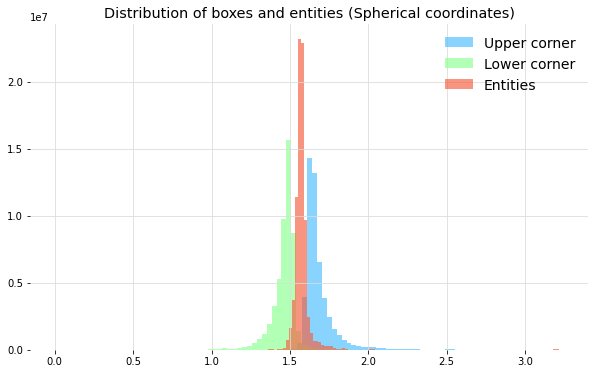

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(entity_boxes.right.view(-1).cpu().numpy(), density=False, color="#4fbfffaa", bins=100, label="Upper corner")
plt.hist(entity_boxes.left.view(-1).cpu().numpy(), density=False, color="#8cff92aa", bins=100, label="Lower corner")
plt.hist(entities_polar.contiguous().view(-1).cpu().numpy(), density=False, color="#f56042aa", bins=100, label="Entities")
plt.title("Distribution of boxes and entities (Spherical coordinates)")
plt.legend(fontsize=14, frameon=False)
plt.show()

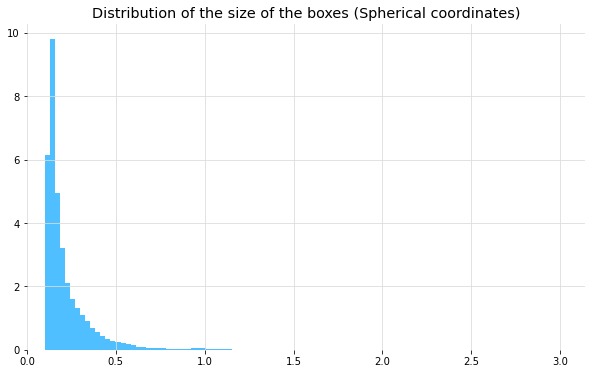

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(sizes.view(-1).cpu().numpy(), density=True, color="#4fbfff", bins=100)
plt.title("Distribution of the size of the boxes (Spherical coordinates)")
plt.xlim(0, 3.14)
plt.show()

In [21]:
entities.size(), entity_boxes.left.size()

(torch.Size([3168, 1024]), torch.Size([49834, 1024]))

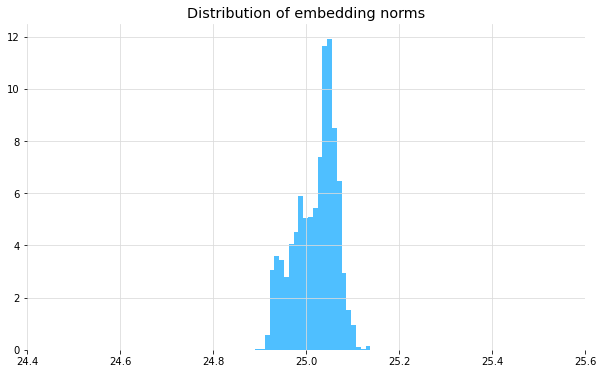

In [27]:
norms = torch.linalg.vector_norm(entities, dim=-1, ord=2)
plt.figure(figsize=(10, 6))
plt.hist(norms.view(-1).cpu().numpy(), density=True, color="#4fbfff", bins=100)
# plt.text(16.62, 70, f'$\mu={torch.mean(norms):.2f}$', fontsize=16)
# plt.text(16.62, 57, f'$\sigma={torch.std(norms):.4f}$', fontsize=16)
plt.title('Distribution of embedding norms')
plt.xlim(24.4, 25.6)
plt.show()

In [23]:
mean = entities.mean(dim=0)
mean_direction = mean / torch.linalg.vector_norm(mean, ord=2)
import torch.nn.functional as f 
normalised_embeddings = entities / torch.linalg.vector_norm(entities, ord=2.0, dim=-1).unsqueeze(-1)
exp_mean_dir = mean_direction.expand(entities.shape[0], -1)
all_cosine_nonsummed = normalised_embeddings * exp_mean_dir
all_cosine = torch.sum(all_cosine_nonsummed, dim=-1)

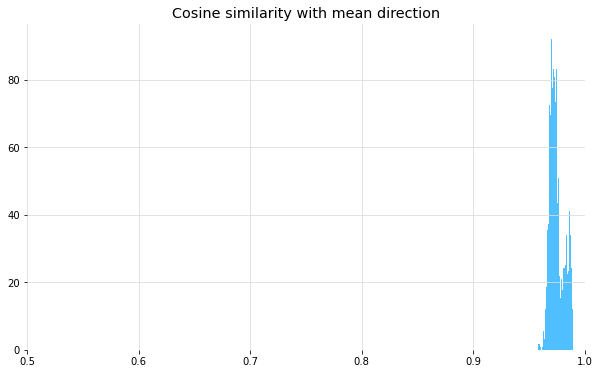

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(all_cosine.view(-1).cpu().numpy(), density=True, color="#4fbfff", bins=100)
plt.title("Cosine similarity with mean direction")
plt.xlim(0.5, 1.0)
plt.show()

# Qualitative analysis of the boxes

In [28]:
rel_catalogue = duck.data.rel_catalogue
ent_catalogue = duck.data.ent_catalogue
num_relations = len(duck.data.rel_catalogue)
ent_to_rel = duck.data.ent_to_rel
properties = load_json("/fsx/matzeni/data/duck/properties.json")

In [29]:
all_relations = [properties[pid]["label"] for pid in rel_catalogue.idx.keys()]
tokenizer = AutoTokenizer.from_pretrained(duck.config.language_model)

In [30]:
def box_labels(entity_label):
    qid = duck.data.label_to_id[entity_label]
    index, tokens = ent_catalogue[qid]
    pids = set(ent_to_rel[qid]) - set(duck.data.stop_rels)
    gold_labels = [properties[pid]["label"] for pid in pids]
    token_ids = torch.tensor(tokens, device="cuda").unsqueeze(0)
    entity_embedding = duck.entity_encoder(token_ids)[0]
    _, entity_embedding = cartesian_to_spherical(entity_embedding)
    all_boxes = duck.rel_encoder(torch.arange(num_relations + 1).cuda())[1:]
    all_boxes = all_boxes[..., :entity_embedding.size(-1)]
    gt_left = all_boxes.left < entity_embedding
    lt_right = all_boxes.right > entity_embedding
    containment_mask = gt_left & lt_right
    containment_mask = containment_mask.all(dim=-1)
    all_rel_ids = torch.arange(num_relations).cuda()
    predicted_rel_ids = list(all_rel_ids[containment_mask])
    predicted_labels = [all_relations[i] for i in predicted_rel_ids]
    dist = BoxEDistance()
    distances = dist(entity_embedding, all_boxes[containment_mask])
    label_to_dist = {p: distances[i].item() for i, p in enumerate(predicted_labels)}
    label_to_dist = dict(sorted(label_to_dist.items(), key=lambda x: x[1]))
    result = {
        k: {"Distance": v, "Correct": (k in gold_labels)}
        for k, v in label_to_dist.items()
    }
    return pd.DataFrame.from_dict(result).transpose()

In [31]:
box_labels("Italy").head(20)

,Distance,Correct
country,0.153975,True
inception,0.161246,True
sport,0.174904,False
owner of,0.178229,False
described by source,0.182098,True
continent,0.182337,True
based on,0.191691,False
uses,0.191889,False
field of this occupation,0.194627,False
office held by head of state,0.195306,True


In [33]:
box_labels("Donald Trump").head(20)

,Distance,Correct
country,0.152376,False
inception,0.158755,False
sport,0.175011,True
owner of,0.178231,True
described by source,0.182912,True
based on,0.185447,False
given name,0.185496,True
date of death,0.186569,False
date of birth,0.18878,True
country of citizenship,0.190559,True


In [35]:
properties = load_json("/fsx/matzeni/data/duck/properties.json")

In [36]:
properties["P1343"]

{'label': 'described by source',
 'description': 'work where this item is described'}